# Train Model to detect Car Plates

### Load the Drive helper and mount (Optional)


In [10]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


### Process DataSet

In [11]:
import os
import torch
from torchvision import transforms
from PIL import Image, ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define a simple transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # For MobileNet
])

# Custom dataset class to load images and masks
class CarPlateDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", "_mask.png"))

        # Load images
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Assuming masks are grayscale

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((256, 256))(mask)
            mask = transforms.ToTensor()(mask)

        return image, mask

### Use MobileNet - U-Net

In [12]:
import torch.nn as nn
from torchvision import models

class MobileNetUNet(nn.Module):
    def __init__(self, num_classes=1):
        super(MobileNetUNet, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=True).features

        # Decoder layers
        self.decoder1 = self._decoder_block(1280, 512)
        self.decoder2 = self._decoder_block(512, 256)
        self.decoder3 = self._decoder_block(256, 128)
        self.decoder4 = self._decoder_block(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x1 = self.backbone[:4](x)  # MobileNet downsampling layers
        x2 = self.backbone[4:](x1)  # MobileNet deep layers

        x = self.decoder1(x2)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.final_conv(x)
        return x

# Instantiate the model
model = MobileNetUNet(num_classes=1)  # for binary segmentation


In [13]:
!pip install tqdm

### Train Model

In [ ]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as fun
from tqdm import tqdm


# Dataset and DataLoader
dataset = CarPlateDataset(image_dir="/content/drive/MyDrive/DataSet/Vehicles", mask_dir="/content/drive/MyDrive/DataSet/VehiclesMasks", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Loss function and optimizer
criterion = BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
epochs = 25
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Wrap the DataLoader with tqdm
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as progress_bar:
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            # Forward pass
            model = model.to(device)
            outputs = model(images)

            # Resize masks to match output size
            masks_resized = fun.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)

            # Compute loss
            loss = criterion(outputs, masks_resized)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update tqdm progress bar with current loss
            progress_bar.set_postfix(loss=loss.item())

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}, Average Loss: {running_loss / len(train_loader):.4f}")
    # print average dice coefficient for the epoch
    print(f"Epoch {epoch + 1}, Average Dice Coefficient: {1 - running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), f"mobilenet_unet.pth")

model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        masks_resized = fun.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        val_loss += criterion(outputs, masks_resized).item()

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch 1/50: 100%|██████████| 203/203 [23:05<00:00,  6.82s/batch, loss=0.0404]


Epoch 1, Average Loss: 0.0993
Epoch 1, Average Dice Coefficient: 0.9007


Epoch 2/50: 100%|██████████| 203/203 [01:23<00:00,  2.42batch/s, loss=0.0366]


Epoch 2, Average Loss: 0.0442
Epoch 2, Average Dice Coefficient: 0.9558


Epoch 3/50: 100%|██████████| 203/203 [01:24<00:00,  2.40batch/s, loss=0.0496]


Epoch 3, Average Loss: 0.0349
Epoch 3, Average Dice Coefficient: 0.9651


Epoch 4/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.0205]


Epoch 4, Average Loss: 0.0235
Epoch 4, Average Dice Coefficient: 0.9765


Epoch 5/50: 100%|██████████| 203/203 [01:25<00:00,  2.36batch/s, loss=0.0126]


Epoch 5, Average Loss: 0.0150
Epoch 5, Average Dice Coefficient: 0.9850


Epoch 6/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.0108]


Epoch 6, Average Loss: 0.0129
Epoch 6, Average Dice Coefficient: 0.9871


Epoch 7/50: 100%|██████████| 203/203 [01:25<00:00,  2.38batch/s, loss=0.0287]


Epoch 7, Average Loss: 0.0295
Epoch 7, Average Dice Coefficient: 0.9705


Epoch 8/50: 100%|██████████| 203/203 [01:26<00:00,  2.36batch/s, loss=0.00884]


Epoch 8, Average Loss: 0.0429
Epoch 8, Average Dice Coefficient: 0.9571


Epoch 9/50: 100%|██████████| 203/203 [01:24<00:00,  2.39batch/s, loss=0.00917]


Epoch 9, Average Loss: 0.0154
Epoch 9, Average Dice Coefficient: 0.9846


Epoch 10/50: 100%|██████████| 203/203 [01:25<00:00,  2.37batch/s, loss=0.0109]


Epoch 10, Average Loss: 0.0120
Epoch 10, Average Dice Coefficient: 0.9880


Epoch 11/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00706]


Epoch 11, Average Loss: 0.0099
Epoch 11, Average Dice Coefficient: 0.9901


Epoch 12/50: 100%|██████████| 203/203 [01:25<00:00,  2.38batch/s, loss=0.0167]


Epoch 12, Average Loss: 0.0096
Epoch 12, Average Dice Coefficient: 0.9904


Epoch 13/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00925]


Epoch 13, Average Loss: 0.0151
Epoch 13, Average Dice Coefficient: 0.9849


Epoch 14/50: 100%|██████████| 203/203 [01:24<00:00,  2.40batch/s, loss=0.00966]


Epoch 14, Average Loss: 0.0109
Epoch 14, Average Dice Coefficient: 0.9891


Epoch 15/50: 100%|██████████| 203/203 [01:25<00:00,  2.37batch/s, loss=0.00684]


Epoch 15, Average Loss: 0.0086
Epoch 15, Average Dice Coefficient: 0.9914


Epoch 16/50: 100%|██████████| 203/203 [01:24<00:00,  2.40batch/s, loss=0.00743]


Epoch 16, Average Loss: 0.0083
Epoch 16, Average Dice Coefficient: 0.9917


Epoch 17/50: 100%|██████████| 203/203 [01:23<00:00,  2.42batch/s, loss=0.00532]


Epoch 17, Average Loss: 0.0082
Epoch 17, Average Dice Coefficient: 0.9918


Epoch 18/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.00879]


Epoch 18, Average Loss: 0.0075
Epoch 18, Average Dice Coefficient: 0.9925


Epoch 19/50: 100%|██████████| 203/203 [01:25<00:00,  2.38batch/s, loss=0.00666]


Epoch 19, Average Loss: 0.0076
Epoch 19, Average Dice Coefficient: 0.9924


Epoch 20/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00806]


Epoch 20, Average Loss: 0.0074
Epoch 20, Average Dice Coefficient: 0.9926


Epoch 21/50: 100%|██████████| 203/203 [01:22<00:00,  2.45batch/s, loss=0.00641]


Epoch 21, Average Loss: 0.0067
Epoch 21, Average Dice Coefficient: 0.9933


Epoch 22/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00483]


Epoch 22, Average Loss: 0.0072
Epoch 22, Average Dice Coefficient: 0.9928


Epoch 23/50: 100%|██████████| 203/203 [01:25<00:00,  2.39batch/s, loss=0.00668]


Epoch 23, Average Loss: 0.0075
Epoch 23, Average Dice Coefficient: 0.9925


Epoch 24/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.0077]


Epoch 24, Average Loss: 0.0066
Epoch 24, Average Dice Coefficient: 0.9934


Epoch 25/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.00569]


Epoch 25, Average Loss: 0.0070
Epoch 25, Average Dice Coefficient: 0.9930


Epoch 26/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.011]


Epoch 26, Average Loss: 0.0065
Epoch 26, Average Dice Coefficient: 0.9935


Epoch 27/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.032]


Epoch 27, Average Loss: 0.0590
Epoch 27, Average Dice Coefficient: 0.9410


Epoch 28/50: 100%|██████████| 203/203 [01:23<00:00,  2.44batch/s, loss=0.0146]


Epoch 28, Average Loss: 0.0263
Epoch 28, Average Dice Coefficient: 0.9737


Epoch 29/50: 100%|██████████| 203/203 [01:22<00:00,  2.46batch/s, loss=0.0106]


Epoch 29, Average Loss: 0.0148
Epoch 29, Average Dice Coefficient: 0.9852


Epoch 30/50: 100%|██████████| 203/203 [01:25<00:00,  2.38batch/s, loss=0.0104]


Epoch 30, Average Loss: 0.0115
Epoch 30, Average Dice Coefficient: 0.9885


Epoch 31/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.00654]


Epoch 31, Average Loss: 0.0105
Epoch 31, Average Dice Coefficient: 0.9895


Epoch 32/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.00932]


Epoch 32, Average Loss: 0.0092
Epoch 32, Average Dice Coefficient: 0.9908


Epoch 33/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.0111]


Epoch 33, Average Loss: 0.0085
Epoch 33, Average Dice Coefficient: 0.9915


Epoch 34/50: 100%|██████████| 203/203 [01:23<00:00,  2.44batch/s, loss=0.00867]


Epoch 34, Average Loss: 0.0079
Epoch 34, Average Dice Coefficient: 0.9921


Epoch 35/50: 100%|██████████| 203/203 [01:23<00:00,  2.44batch/s, loss=0.00738]


Epoch 35, Average Loss: 0.0076
Epoch 35, Average Dice Coefficient: 0.9924


Epoch 36/50: 100%|██████████| 203/203 [01:24<00:00,  2.42batch/s, loss=0.0242]


Epoch 36, Average Loss: 0.0074
Epoch 36, Average Dice Coefficient: 0.9926


Epoch 37/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.0067]


Epoch 37, Average Loss: 0.0071
Epoch 37, Average Dice Coefficient: 0.9929


Epoch 38/50: 100%|██████████| 203/203 [01:23<00:00,  2.43batch/s, loss=0.00612]


Epoch 38, Average Loss: 0.0071
Epoch 38, Average Dice Coefficient: 0.9929


Epoch 39/50: 100%|██████████| 203/203 [01:23<00:00,  2.44batch/s, loss=0.0272]


Epoch 39, Average Loss: 0.0213
Epoch 39, Average Dice Coefficient: 0.9787


Epoch 40/50: 100%|██████████| 203/203 [01:23<00:00,  2.42batch/s, loss=0.0318]


Epoch 40, Average Loss: 0.0307
Epoch 40, Average Dice Coefficient: 0.9693


Epoch 41/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00732]


Epoch 41, Average Loss: 0.0123
Epoch 41, Average Dice Coefficient: 0.9877


Epoch 42/50: 100%|██████████| 203/203 [01:22<00:00,  2.45batch/s, loss=0.00983]


Epoch 42, Average Loss: 0.0094
Epoch 42, Average Dice Coefficient: 0.9906


Epoch 43/50: 100%|██████████| 203/203 [01:23<00:00,  2.42batch/s, loss=0.00689]


Epoch 43, Average Loss: 0.0082
Epoch 43, Average Dice Coefficient: 0.9918


Epoch 44/50: 100%|██████████| 203/203 [01:23<00:00,  2.44batch/s, loss=0.013]


Epoch 44, Average Loss: 0.0082
Epoch 44, Average Dice Coefficient: 0.9918


Epoch 45/50: 100%|██████████| 203/203 [01:22<00:00,  2.45batch/s, loss=0.00564]


Epoch 45, Average Loss: 0.0075
Epoch 45, Average Dice Coefficient: 0.9925


Epoch 46/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00997]


Epoch 46, Average Loss: 0.0071
Epoch 46, Average Dice Coefficient: 0.9929


Epoch 47/50: 100%|██████████| 203/203 [01:23<00:00,  2.42batch/s, loss=0.00689]


Epoch 47, Average Loss: 0.0069
Epoch 47, Average Dice Coefficient: 0.9931


Epoch 48/50: 100%|██████████| 203/203 [01:27<00:00,  2.31batch/s, loss=0.00402]


Epoch 48, Average Loss: 0.0066
Epoch 48, Average Dice Coefficient: 0.9934


Epoch 49/50: 100%|██████████| 203/203 [01:25<00:00,  2.38batch/s, loss=0.00727]


Epoch 49, Average Loss: 0.0064
Epoch 49, Average Dice Coefficient: 0.9936


Epoch 50/50: 100%|██████████| 203/203 [01:24<00:00,  2.41batch/s, loss=0.00515]


Epoch 50, Average Loss: 0.0062
Epoch 50, Average Dice Coefficient: 0.9938
Validation Loss: 0.0113


In [20]:
image_path = "/content/drive/MyDrive/005.jpg"

### test model

<ipython-input-21-847b95fcceeb>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenet_unet.pth", map_location=

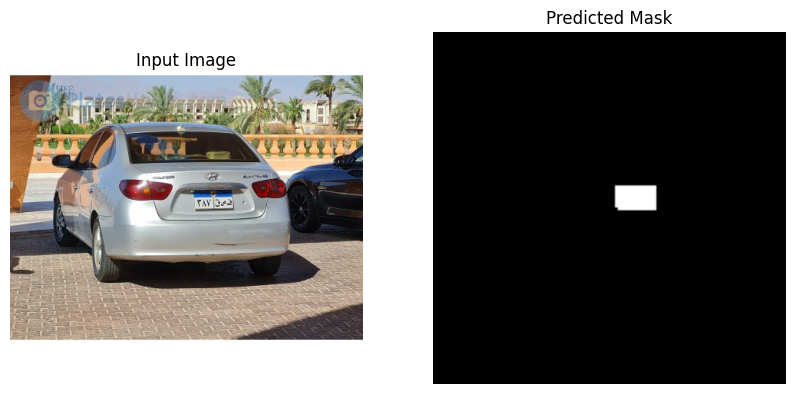

In [21]:
import torch
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt


# Load the model
model = MobileNetUNet(num_classes=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/mobilenet_unet.pth", map_location=torch.device('cpu')))
model.eval()

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust to your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load a sample image
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Inference
with torch.no_grad():
    output = model(input_image)

# Process the output (e.g., apply a threshold for binary segmentation)
predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert to numpy
predicted_mask = (predicted_mask > 0.5).astype("uint8")  # Binarize


# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")
plt.axis("off")

plt.show()


### Extract Region of interset

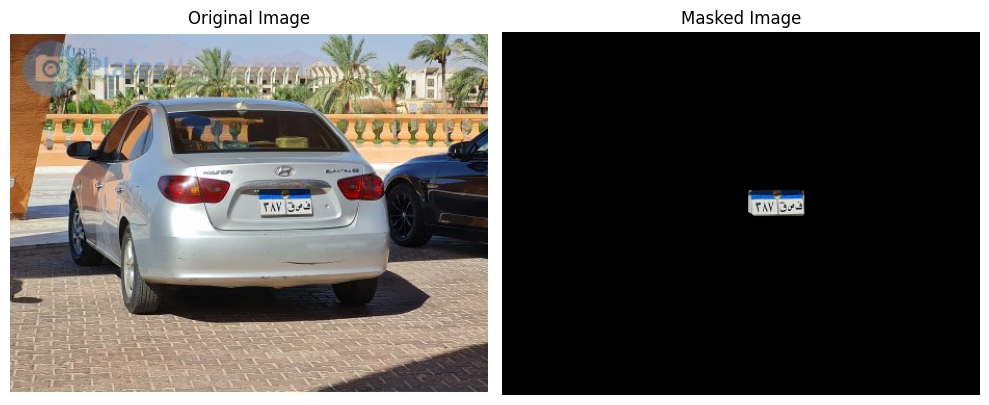

False

In [23]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
image = cv2.imread(image_path)

# Scale mask if values are in [0, 1]
if predicted_mask.max() <= 1.0:
    predicted_mask = (predicted_mask * 255).astype(np.uint8)

# Resize mask to match image dimensions
predicted_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))

# Ensure the mask is binary
predicted_mask = (predicted_mask > 127).astype(np.uint8) * 255

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=predicted_mask)

# crop masked image
x, y, w, h = cv2.boundingRect(predicted_mask)
cropped_masked_image = masked_image[y:y+h, x:x+w]


# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# save the masked image
cv2.imwrite("data/output/masked_image.jpg", cropped_masked_image)


Extract text From Image